# Модель для соотношения матрица-наполнитель

Постановка задачи:
    Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель. 


In [1]:
# Импортирую необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from sklearn import metrics
import pickle

# Импорт библиотеки TensorFlow
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

C:\Users\sumbu\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\sumbu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\sumbu\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


2.11.0


In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#Загрузим уже подготовленный датасет

df = pd.read_excel('composites.xlsx', index_col=0)
df.head()

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
1,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0,0,4.0,60.0
3,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0,0,5.0,47.0
4,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,57.0
5,2.767918,2000.0,748.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,60.0
6,2.569620,1910.0,807.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0,0,5.0,70.0


#### Проведем препроцессинг данных

In [4]:
y_columns = ['Соотношение матрица-наполнитель']
X_columns = [
  'Плотность, кг/м3',
  'модуль упругости, ГПа', 
  'Количество отвердителя, м.%',
  'Содержание эпоксидных групп,%_2', 
  'Температура вспышки, С_2',
  'Поверхностная плотность, г/м2', 
  'Модуль упругости при растяжении, ГПа',
  'Прочность при растяжении, МПа', 
  'Потребление смолы, г/м2',
  'Угол нашивки, град', 
  'Шаг нашивки', 
  'Плотность нашивки'
]

y = df.loc[:, y_columns]
X = df.loc[:, X_columns]

In [5]:
# Разделим данные на категориальные и численные

X_categorical = ['Угол нашивки, град']
X_continuous = [column for column in X_columns if column not in X_categorical]

In [6]:
# Препроцессор 

preprocessor = ColumnTransformer(transformers=[
        ("continuous", StandardScaler(), X_continuous),
        ("categorical", OrdinalEncoder(), X_categorical)
])

In [7]:
print(X_categorical)

['Угол нашивки, град']


In [8]:
# Разделяем на тренировочную и тестовую выборку

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print('X_train:', X_train_raw.shape, 'y_train:', y_train.shape)
print('X_test:', X_test_raw.shape, 'y_test:', y_test.shape)

X_train: (700, 12) y_train: (700, 1)
X_test: (300, 12) y_test: (300, 1)


In [9]:
# Выполним препроцессинг входных переменных

X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

DummyRegressor, возвращающая среднее, для оценки качества модели.

In [10]:
# Базовая модель

base_model = DummyRegressor(strategy='mean')

# Предсказание базовой модели

base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)

#### MLPRegressor из библиотеки sklearn.

In [11]:
from sklearn.neural_network import MLPRegressor

In [12]:
# Настраиваем нейросеть
model = MLPRegressor(
    hidden_layer_sizes = (24, 24),
    activation = 'relu',
    solver='adam',
    max_iter=5000,
    early_stopping = True,
    random_state=42, 
    verbose=True
)

In [13]:
%%time
# Запускаем нейросеть

model.fit(X_train, y_train)

Iteration 1, loss = 7.03859602
Validation score: -12.634015
Iteration 2, loss = 6.55026278
Validation score: -11.723713
Iteration 3, loss = 6.09193389
Validation score: -10.873453
Iteration 4, loss = 5.66049438
Validation score: -10.070861
Iteration 5, loss = 5.25632221
Validation score: -9.298301
Iteration 6, loss = 4.86562168
Validation score: -8.556418
Iteration 7, loss = 4.49224120
Validation score: -7.836281
Iteration 8, loss = 4.13193869
Validation score: -7.129951
Iteration 9, loss = 3.78622833
Validation score: -6.440684
Iteration 10, loss = 3.45086946
Validation score: -5.765626
Iteration 11, loss = 3.12538280
Validation score: -5.113431
Iteration 12, loss = 2.81331521
Validation score: -4.489173
Iteration 13, loss = 2.51381396
Validation score: -3.882110
Iteration 14, loss = 2.22906212
Validation score: -3.304495
Iteration 15, loss = 1.96330872
Validation score: -2.775155
Iteration 16, loss = 1.72072421
Validation score: -2.306429
Iteration 17, loss = 1.50467852
Validation sc

MLPRegressor(early_stopping=True, hidden_layer_sizes=(24, 24), max_iter=5000,
             random_state=42, verbose=True)

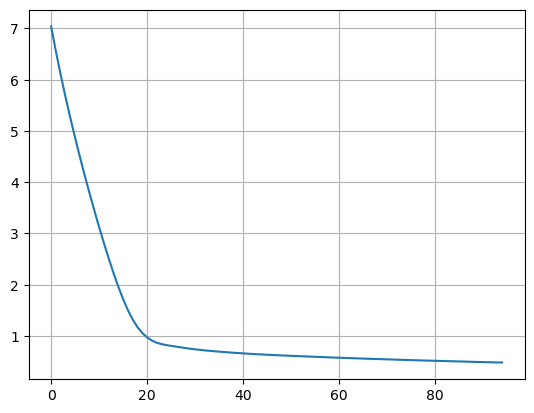

In [14]:
# График ошибки

plt.plot(model.loss_curve_)
plt.grid(True)
plt.show()

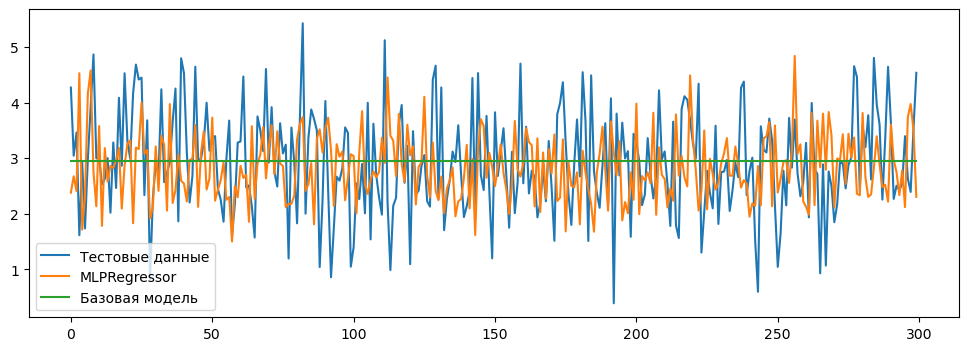

In [15]:
# Предсказание нейросети
y_pred_skl = model.predict(X_test)

# Визуализация
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(y_test.values, label='Тестовые данные')
ax.plot(y_pred_skl, label='MLPRegressor')
ax.plot(y_pred_base, label='Базовая модель')
ax.legend()
plt.show()

In [16]:
def get_metrics(model_name, y, y_pred):
    stat = pd.DataFrame()
    stat.loc[model_name, 'R2'] = metrics.r2_score(y, y_pred)
    stat.loc[model_name, 'RMSE'] = metrics.mean_squared_error(y, y_pred, squared=False) * -1
    stat.loc[model_name, 'MAE'] = metrics.mean_absolute_error(y, y_pred) * -1
    stat.loc[model_name, 'max_error'] = metrics.max_error(y, y_pred) * -1
    return stat

In [17]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare = get_metrics('DummyRegressor', y_test, y_pred_base)
compare = compare.append(get_metrics('MLPRegressor', y_test, y_pred_skl))
compare

,R2,RMSE,MAE,max_error
DummyRegressor,-0.000744,-0.924041,-0.739327,-2.554458
MLPRegressor,-0.340053,-1.069278,-0.865359,-2.913857


Нейросеть, построенная с помощью MLPRegressor, возвращает данные, похожие на исходные. Ошибка по всем метрикам значительно хуже, чем у базовой модели. Возможно, ошибку можно уменьшить, экспериментируя со структурой нейросети.

#### Построим нейронную сеть с помощью библиотеки TensorFlow

In [18]:
model_tf = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(12,), name='in'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, name='out')])


In [19]:
model_tf.compile(optimizer='adam',
                 loss='mse',
                 metrics=['mae'])


In [20]:
model_tf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 104       
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 out (Dense)                 (None, 1)                 9         
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Функция для построения графика ошибки

def model_loss_plot(model_history):
    plt.figure(figsize=(10, 5))
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('График потерь модели', size=12)
    plt.ylabel('Средняя абсолютная ошибка', size=12)
    plt.xlabel('Эпоха', size=12)
    plt.legend(['loss', 'val_loss'], loc='best')
    plt.show()

In [22]:
%%time
#Обучение нейросети

history = model_tf.fit(
  X_train, 
  y_train, 
  epochs=100, 
  validation_split=0.3, 
  verbose=1
)

Epoch 1/100
16/16 [==============================] - 1s 23ms/step - loss: 7.8324 - mae: 2.6433 - val_loss: 7.9527 - val_mae: 2.6340
Epoch 2/100
16/16 [==============================] - 0s 6ms/step - loss: 6.8440 - mae: 2.4410 - val_loss: 6.9739 - val_mae: 2.4356
Epoch 3/100
16/16 [==============================] - 0s 6ms/step - loss: 5.9655 - mae: 2.2475 - val_loss: 6.0777 - val_mae: 2.2397
Epoch 4/100
16/16 [==============================] - 0s 7ms/step - loss: 5.1635 - mae: 2.0537 - val_loss: 5.2563 - val_mae: 2.0439
Epoch 5/100
16/16 [==============================] - 0s 7ms/step - loss: 4.4377 - mae: 1.8665 - val_loss: 4.5061 - val_mae: 1.8598
Epoch 6/100
16/16 [==============================] - 0s 7ms/step - loss: 3.7914 - mae: 1.6976 - val_loss: 3.8497 - val_mae: 1.6846
Epoch 7/100
16/16 [==============================] - 0s 8ms/step - loss: 3.2432 - mae: 1.5386 - val_loss: 3.2768 - val_mae: 1.5134
Epoch 8/100
16/16 [==============================] - 0s 6ms/step - loss: 2.7989 - 

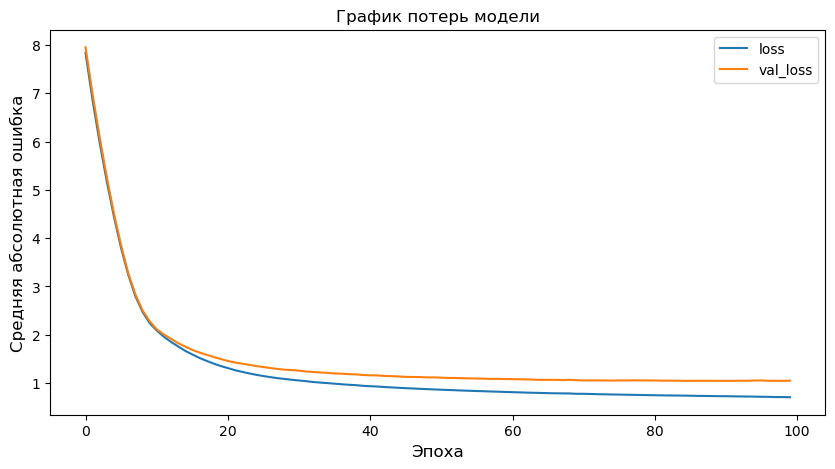

In [23]:
model_loss_plot(history)

In [24]:
# Проверяем точность нейросети на тестовых данных

model_tf.evaluate(X_test, y_test)

10/10 [==============================] - 0s 2ms/step - loss: 1.0407 - mae: 0.8320


[1.0406581163406372, 0.8319597244262695]

In [25]:
# Предсказание 

y_pred_tf = model_tf.predict(X_test)

10/10 [==============================] - 0s 2ms/step


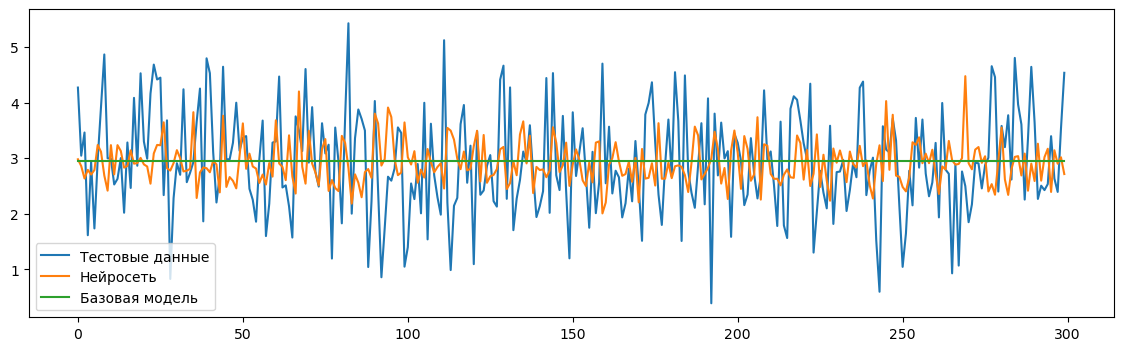

In [26]:
# Визуализация
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(y_test.values, label='Тестовые данные')
ax.plot(y_pred_tf, label='Нейросеть')
ax.plot(y_pred_base, label='Базовая модель')
ax.legend()
plt.show()

Попробуем сократить количество эпох, на графике видно что примерно начиная с 8й эпохи, ошибка остается на постоянном уровне

In [27]:
# model_tf_2 = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(12,), name='in'),
#     tf.keras.layers.Dense(8, activation='relu'),
#     tf.keras.layers.Dense(8, activation='relu'),
#     tf.keras.layers.Dense(1, name='out')])

# model_tf_2.compile(optimizer='adam',
#                  loss='mse',
#                  metrics=['mae'])

In [28]:
# %%time
# #Обучение нейросети

# history_2 = model_tf_2.fit(
#   X_train_norm, 
#   y_train, 
#   epochs=10, 
#   validation_split=0.3, 
#   verbose=1,
#   callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
# )

In [29]:
# model_loss_plot(history_2)

In [30]:
# Проверяем точность нейросети на тестовых данных

# model_tf_2.evaluate(X_test_norm, y_test)

In [31]:
# # Предсказание 

# y_pred_tf_2 = model_tf_2.predict(X_test_norm)

In [32]:
# # Визуализация
# fig, ax = plt.subplots(figsize=(14, 4))
# ax.plot(y_test.values, label='Данные')
# ax.plot(y_pred_tf_2, label='Нейросеть c ранней остановкой')
# ax.plot(y_pred_base, label='Базовая модель')
# ax.legend()
# plt.show()

In [33]:
# Сравнение предсказаний базовой модели и лучшей модели на тестовом множестве
compare = compare.append(get_metrics('Нейросеть TF', y_test, y_pred_tf))
#compare = compare.append(get_metrics('Нейросеть TF с ранней остановкой', y_test, y_pred_tf_2))
compare

,R2,RMSE,MAE,max_error
DummyRegressor,-0.000744,-0.924041,-0.739327,-2.554458
MLPRegressor,-0.340053,-1.069278,-0.865359,-2.913857
Нейросеть TF,-0.219687,-1.020127,-0.831960,-2.694309


Сохраним параметры модели для веб-приложения

In [34]:
models_path = 'models/'

In [35]:
def save_object_with_pickle(obj, obj_name):
  filename = models_path + obj_name
  file = open(filename, 'wb')
  pickle.dump(obj, file)
  file.close()

    
def load_object_with_pickle(obj_name):
  filename = models_path + obj_name
  file = open(filename, 'rb')
  obj = pickle.load(file)
  file.close()
  return obj

In [36]:
save_object_with_pickle(preprocessor, 'preprocessor')

In [37]:
model_tf.save(models_path)

INFO:tensorflow:Assets written to: models/assets


INFO:tensorflow:Assets written to: models/assets


In [38]:
s = keras.models.load_model('C:/Users/sumbu/Downloads/Data/ВКР/Moe/models')

In [39]:
s